In [87]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_fscore_support, matthews_corrcoef, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

Setting configurations for model and preprocessing

In [2]:
class configuration:
    seed = 1234
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    batch_size = 16
    init_lr = 1e-3
    epochs = 3
    img_size = 100
    class_mode = "binary"
    n_CLASS = 2
    interpolation = "nearest"

In [3]:
tf.random.set_seed(configuration.seed)
np.random.seed(configuration.seed)
random.seed(configuration.seed)
os.environ["PYTHONHASHSEED"] = str(configuration.seed)

In [4]:
configuration.seed

1234

In [5]:
train_dir = "../input/bms-molecular-translation/train"
arranged_data_path = "../input/bms-molecular-translation/arranged_bms_train_labels.csv"

In [6]:
arranged_data = pd.read_csv(arranged_data_path)

In [36]:
print(arranged_data.shape)
print(arranged_data.head(2))
print(arranged_data.columns)

(2424186, 32)
   Unnamed: 0      image_id  \
0           0  000011a64c74   
1           1  000019cc0cd2   

                                               InChI  \
0  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
1  InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...   

                                          image_path   formula  \
0  ../input/bms-molecular-translation/train/0/0/0...  C13H20OS   
1  ../input/bms-molecular-translation/train/0/0/0...  C21H30O4   

                                                   c  c_flg  \
0            c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14      1   
1  c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-1...      1   

                         h  h_flg    b  ...  Br Cl  F  I  N  O  P  S  Si  \
0  h5-7,9,11,14H,8H2,1-4H3      1  NaN  ...   0  0  0  0  0  1  0  1   0   
1  h13-16,19H,4-11H2,1-3H3      1  NaN  ...   0  0  0  0  0  4  0  0   0   

   total  
0     35  
1     55  

[2 rows x 32 columns]
Index(['Unnamed: 0', 'image_id', 'InChI', 'image_

Here the columns [c,c_flg,h,h_flg,b,b_flg,t,t_flg,m,m_flg,s,s_flg,i,i_flg] represent the stereochemistry of the model. Stereochemistry involves three-dimensional arrangement of atoms and molecules and the effect of this on chemical reactions. 

For example, InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1 is an InChI label where stereochemistry information begins from /t.

/t is the sublayer for tetrahedral centers, complemented by two indicator stereo layers '/m1' and '/s1'. /m1 means that the selected one has the inverse arrangement. /s1 means there is absolute stereochemistry. Which is basically the spatial arrangement of atoms or groups in a chemical compound about an asymmetric atom, and such compounds are  called Chiral compounds.

Similarly different flags represent different chemical characteristics.

Here we try to build a model to predict the chirality of each chemical compound.

In [37]:
print(arranged_data['s_flg'].value_counts())

0    2028036
1     396150
Name: s_flg, dtype: int64


In our dataset of 2.4 million compounds, nearly 2 million compounds are not chiral compounds, that is when the compounds mirror image is rotated or translated, it will not be able to superimpose on the original compound. Whereas, 0.4 million have the chirality flag as 1 depicting they are chiral compounds. 

In [9]:
d = arranged_data.sample(n=1000)

We only take a subset of 1000 chemical compunds, to reduce computation time and memory optimization.

In [10]:
print(d.shape)
print(d['s_flg'].value_counts())

(1000, 32)
0    847
1    153
Name: s_flg, dtype: int64


In [11]:
data = d[["image_path"]].copy()
data["label"] = d["s_flg"].astype("str")

In [12]:
data.shape

(1000, 2)

In [13]:
data.columns

Index(['image_path', 'label'], dtype='object')

Method to generate Image data for augmentation of image data in realtime. ImageDataGenerator is a package that helps transform and preprocess training images. Here we transform the image by resizing it and bringing it to the same color gradient.

In [14]:
data_augumentation = A.Compose([A.Normalize(mean=configuration.norm_mean, std=configuration.norm_std, max_pixel_value=255, p=1.0)])

def image_data_transformation(image):
    image = data_augumentation(image=image.astype(np.uint8))["image"]
    return image

In [15]:
training_image_data = ImageDataGenerator(preprocessing_function = image_data_transformation)
validation_image_data = ImageDataGenerator(preprocessing_function = image_data_transformation)

In [16]:
def create_dataset(dataset):
    data_set = training_image_data.flow_from_dataframe(
        dataframe=dataset,
        directory = None,
        seed = configuration.seed,
        x_col = "image_path",
        y_col = "label",
        target_size = (configuration.img_size, configuration.img_size),
        class_mode = configuration.class_mode,
        interpolation = configuration.interpolation,
        shuffle = True,
        batch_size = configuration.batch_size,
        validate_filenames=False)
    return data_set

Splitting data for training and validation

In [17]:
train, val = train_test_split(data, test_size=0.05, random_state=configuration.seed, stratify=data["label"])

In [18]:
print(train.head(2))
print(train.shape)

                                                image_path label
1533290  ../input/bms-molecular-translation/train/a/1/d...     1
657676   ../input/bms-molecular-translation/train/4/5/6...     0
(950, 2)


In [19]:
print(val.head(2))
print(val.shape)

                                                image_path label
1671479  ../input/bms-molecular-translation/train/b/0/7...     0
633435   ../input/bms-molecular-translation/train/4/2/d...     0
(50, 2)


In [20]:
valid_set = create_dataset(val)
train_set = create_dataset(train)

Found 50 non-validated image filenames belonging to 2 classes.
Found 950 non-validated image filenames belonging to 2 classes.


From the 1000 dataset we have 950 images in the training dataset and 50 in validation


# Creating Neural Network Model using Keras

In [21]:
def create_model():
    model = Sequential()
    model.add(EfficientNetB4(input_shape = (configuration.img_size, configuration.img_size, 3), include_top=False, weights = "imagenet", drop_connect_rate=0.6))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="sigmoid"))
    return model

model = create_model()
model.summary()

2022-08-12 08:48:43.815487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 4, 4, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 17,550,409
Non-trainable params: 125,207
_________________________________________________________________


Here we build a neural network model using EfficientNet which is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient.
EfficientNetB4 is an architecture used for image classification which comes with weights pre-trained on ImageNet. The input to this network is the training dataset which 950 chemical compounds and has the feature as pixels of the image, which has been set to 100 during preprocessing.

In [22]:
step_size_train = train_set.n // train_set.batch_size
step_size_valid = valid_set.n // valid_set.batch_size

In [23]:
model = create_model()
model.load_weights("bms_s_model.h5")
    
loss = BinaryCrossentropy(from_logits = False, name="binary_crossentropy")

lr = CosineDecay(initial_learning_rate = configuration.init_lr, decay_steps = step_size_train * configuration.epochs)

model.compile(optimizer = Adam(learning_rate=lr), loss=loss, metrics=["binary_accuracy"])

checkpoint_cb = ModelCheckpoint("bms_best_model.h5", save_best_only=True, monitor="val_loss", mode="min")

In [24]:
history = model.fit(train_set,
                    validation_data = valid_set,
                    epochs = configuration.epochs,
                    batch_size = configuration.batch_size,
                    steps_per_epoch = step_size_train,
                    validation_steps = step_size_valid,
                    callbacks=[checkpoint_cb])

model.save("bms_model.h5")

Epoch 1/3
59/59 [==============================] - 288s 4s/step - loss: 0.4865 - binary_accuracy: 0.8062 - val_loss: 0.5228 - val_binary_accuracy: 0.8333
Epoch 2/3
59/59 [==============================] - 234s 4s/step - loss: 0.3972 - binary_accuracy: 0.8426 - val_loss: 0.4541 - val_binary_accuracy: 0.8333
Epoch 3/3
59/59 [==============================] - 208s 4s/step - loss: 0.3310 - binary_accuracy: 0.8662 - val_loss: 0.4421 - val_binary_accuracy: 0.8333


Reducing Loss percentage indicates that with every epoch, the model is learning better and is increasing its accuracy. Here we have restricted our model to run minimal epochs, due to a dense dataset, as we increase the epoch, performance will increase.

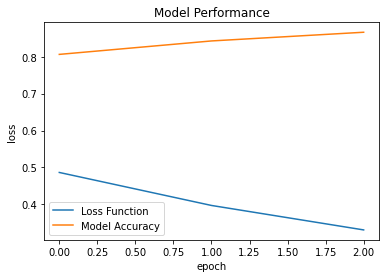

In [35]:
plot.plot(history.history['loss'])
plot.plot(history.history['binary_accuracy'])
plot.title('Model Performance')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['Loss Function', 'Model Accuracy'], loc='best')
plot.show()

In [59]:
predictions = []
formulae = []
for i, (test, formula_list) in enumerate(tqdm(train_set)):
    if i >= len(train_set):
        break
    predicts = model.predict(test)
    for predict, formula in zip(predicts, formula_list):
        predictions.append((predict[0] > 0.05).astype(int))
        formulae.append(formula)

  0%|          | 0/60 [00:00<?, ?it/s]

1/1 [==============================] - 1s 658ms/step


In [65]:
# data to be plotted
x = np.arange(1, 951)
y = sorted(predictions, key = lambda x:float(x))

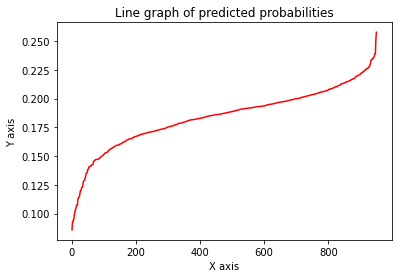

In [64]:
plot.title("Line graph of predicted probabilities")
plot.xlabel("X axis")
plot.ylabel("Y axis")
plot.plot(x, y, color ="red")
plot.show()

In [63]:
model.evaluate(valid_set)

4/4 [==============================] - 3s 644ms/step - loss: 0.4339 - binary_accuracy: 0.8400


[0.43386122584342957, 0.8399999737739563]

Average F1 score of model -  0.7668711656441718

Classification Report of model: 
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       808
           1       0.68      0.88      0.77       142

    accuracy                           0.92       950
   macro avg       0.83      0.90      0.86       950
weighted avg       0.93      0.92      0.92       950


Macro scores of model - 
(0.828577307299353, 0.9036309440803236, 0.8592932702426703, None)

Micro scores of model - 
(0.92, 0.92, 0.92, None)

Weighted average scores of model - 
(0.9331950278124646, 0.92, 0.9240860298875125, None)

The model's area under ROC curve is -  0.9036309440803235


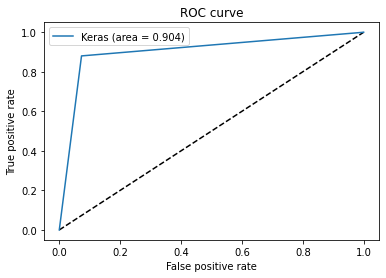

In [92]:
print("Average F1 score of model - ", f1_score(formulae, predictions))
print("\nClassification Report of model: ")
print(classification_report(formulae, predictions))
print("\nMacro scores of model - ")
print(precision_recall_fscore_support(formulae, predictions, average='macro'))
print("\nMicro scores of model - ")
print(precision_recall_fscore_support(formulae, predictions, average='micro'))
print("\nWeighted average scores of model - ")
print(precision_recall_fscore_support(formulae, predictions, average='weighted'))
print("\nThe model's area under ROC curve is - ", roc_auc_score(true, predictions))

fpr, tpr, thresholds = roc_curve(formulae, predictions)
plot.figure(1)
plot.plot([0, 1], [0, 1], 'k--')
plot.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(roc_auc_score(formulae, predictions)))
plot.xlabel('False positive rate')
plot.ylabel('True positive rate')
plot.title('ROC curve')
plot.legend(loc='best')
plot.show()

Our model which predicts the chirality of chemical compounds has achieved a validation accuracy of 92% with a log loss of 0.43. 

The model achieved an average F1-score of 0.76, with individual F1-score of each class as 0.95 for non-chiral class prediction and 0.77 for chiral class prediction.